# Evidencia Portafolio

Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

Por: Alan Contreras Prieto - A01749667

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
#pip install 

In [69]:
#import funcionesIA as f_IA
from funcionesIA import *
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Introducción: 

En el sector energético moderno, la estabilidad y eficiencia de la red eléctrica dependen fundamentalmente del correcto funcionamiento de sus componentes críticos, siendo los transformadores eléctricos uno de los activos más vitales. El problema central que aborda este proyecto es la predicción de series de tiempo multivariadas para estimar el comportamiento futuro de un transformador eléctrico. Específicamente, se busca predecir la Temperatura del Aceite (OT - Oil Temperature) basándose en datos históricos de carga eléctrica y temperatura. Los transformadores generan calor durante su operación; si este calor no se disipa correctamente o excede los límites operativos, puede provocar fallos catastróficos, interrupciones del servicio y daños irreversibles al equipo.

**Relevancia**: La capacidad de predecir la temperatura del transformador con antelación tiene un impacto directo en la implementación de estrategias de mantenimiento predictivo.

* Seguridad: Previene explosiones o incendios causados por sobrecalentamiento.

* Eficiencia Económica: Reduce los costos asociados con el mantenimiento correctivo de emergencia y prolonga la vida útil de activos costosos.

* Estabilidad de la Red: Permite a los operadores gestionar mejor las cargas en horas pico, sabiendo de antemano si un transformador está en riesgo de saturación térmica.

# Datos: 


### Descripción del Dataset y fuente:

Para este proyecto se utiliza el Electricity Transformer Dataset (ETDataset), un conjunto de datos público recolectado de transformadores eléctricos reales en China.

En la carpeta data se encuentran 2 versiones de diferentes transformadores, una con registros cada 15 minutos y otra con registros cada hora.

Contenido: El dataset contiene registros históricos de dos años.

Variables: Cada registro incluye su fecha de registro y 7 variables númericas:

* date: fecha de registro

* HUFL: High Use Full Load (Carga completa de uso alto).

* HULL: High Use Less Load (Menos carga de uso alto).

* MUFL: Medium Use Full Load.

* MULL: Medium Use Less Load.

* LUFL: Low Use Full Load.

* LULL: Low Use Less Load.

* OT: Oil Temperature (Temperatura del aceite) - Variable Objetivo.

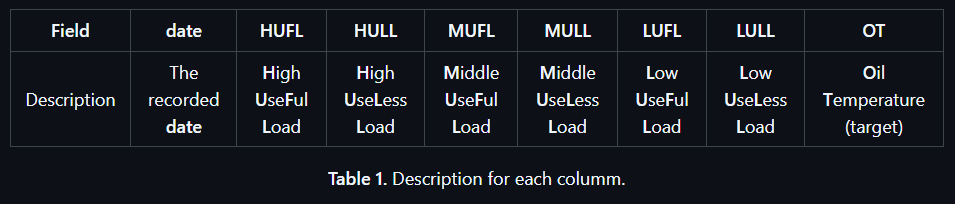

Repositorio GitHub de Zhouhaoyi - ETDataset 

Link: https://github.com/zhouhaoyi/ETDataset/

```bibtex
@inproceedings{haoyietal-informer-2021,
  author    = {Haoyi Zhou and
               Shanghang Zhang and
               Jieqi Peng and
               Shuai Zhang and
               Jianxin Li and
               Hui Xiong and
               Wancai Zhang},
  title     = {Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting},
  booktitle = {The Thirty-Fifth {AAAI} Conference on Artificial Intelligence, {AAAI} 2021, Virtual Conference},
  volume    = {35},
  number    = {12},
  pages     = {11106--11115},
  publisher = {{AAAI} Press},
  year      = {2021},
}

## Carga de datos

In [ ]:
datamin = False
if datamin:
    data = pd.read_csv("data/ETTm2.csv") #Version con registros cada 15 min
else:
    data = pd.read_csv("data/ETTh2.csv") #Version con registros cada hora
#
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...
2018-06-26 18:45:00,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
2018-06-26 19:00:00,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
2018-06-26 19:15:00,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501


## Análisis

Matriz de correlación

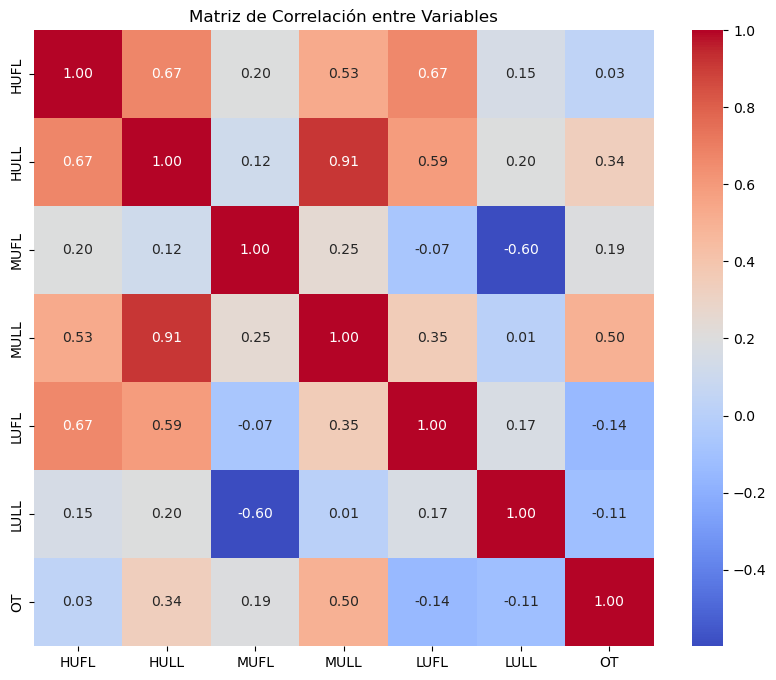

In [71]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables')
plt.show()

Información de tipos de datos y nulos

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69680 entries, 2016-07-01 00:00:00 to 2018-06-26 19:45:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    69680 non-null  float64
 1   HULL    69680 non-null  float64
 2   MUFL    69680 non-null  float64
 3   MULL    69680 non-null  float64
 4   LUFL    69680 non-null  float64
 5   LULL    69680 non-null  float64
 6   OT      69680 non-null  float64
dtypes: float64(7)
memory usage: 4.3 MB


Estadísticas descriptivas:

In [73]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,37.219411,8.554209,43.861438,8.340187,-3.430701,-2.084888,26.609799
std,10.243442,6.031270,13.061909,4.369039,6.154438,6.013584,11.886536
min,0.000000,-29.319000,10.427000,-6.648000,-14.617000,-31.462000,-2.646500
25%,30.156000,4.523000,37.421001,5.656000,-9.286000,-2.505000,16.469500
50%,37.277000,9.131000,41.415001,9.328000,-3.774000,-1.226000,26.577000
75%,44.146000,13.235000,46.186001,11.285000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,29.808001,17.218000,3.731000,58.876999


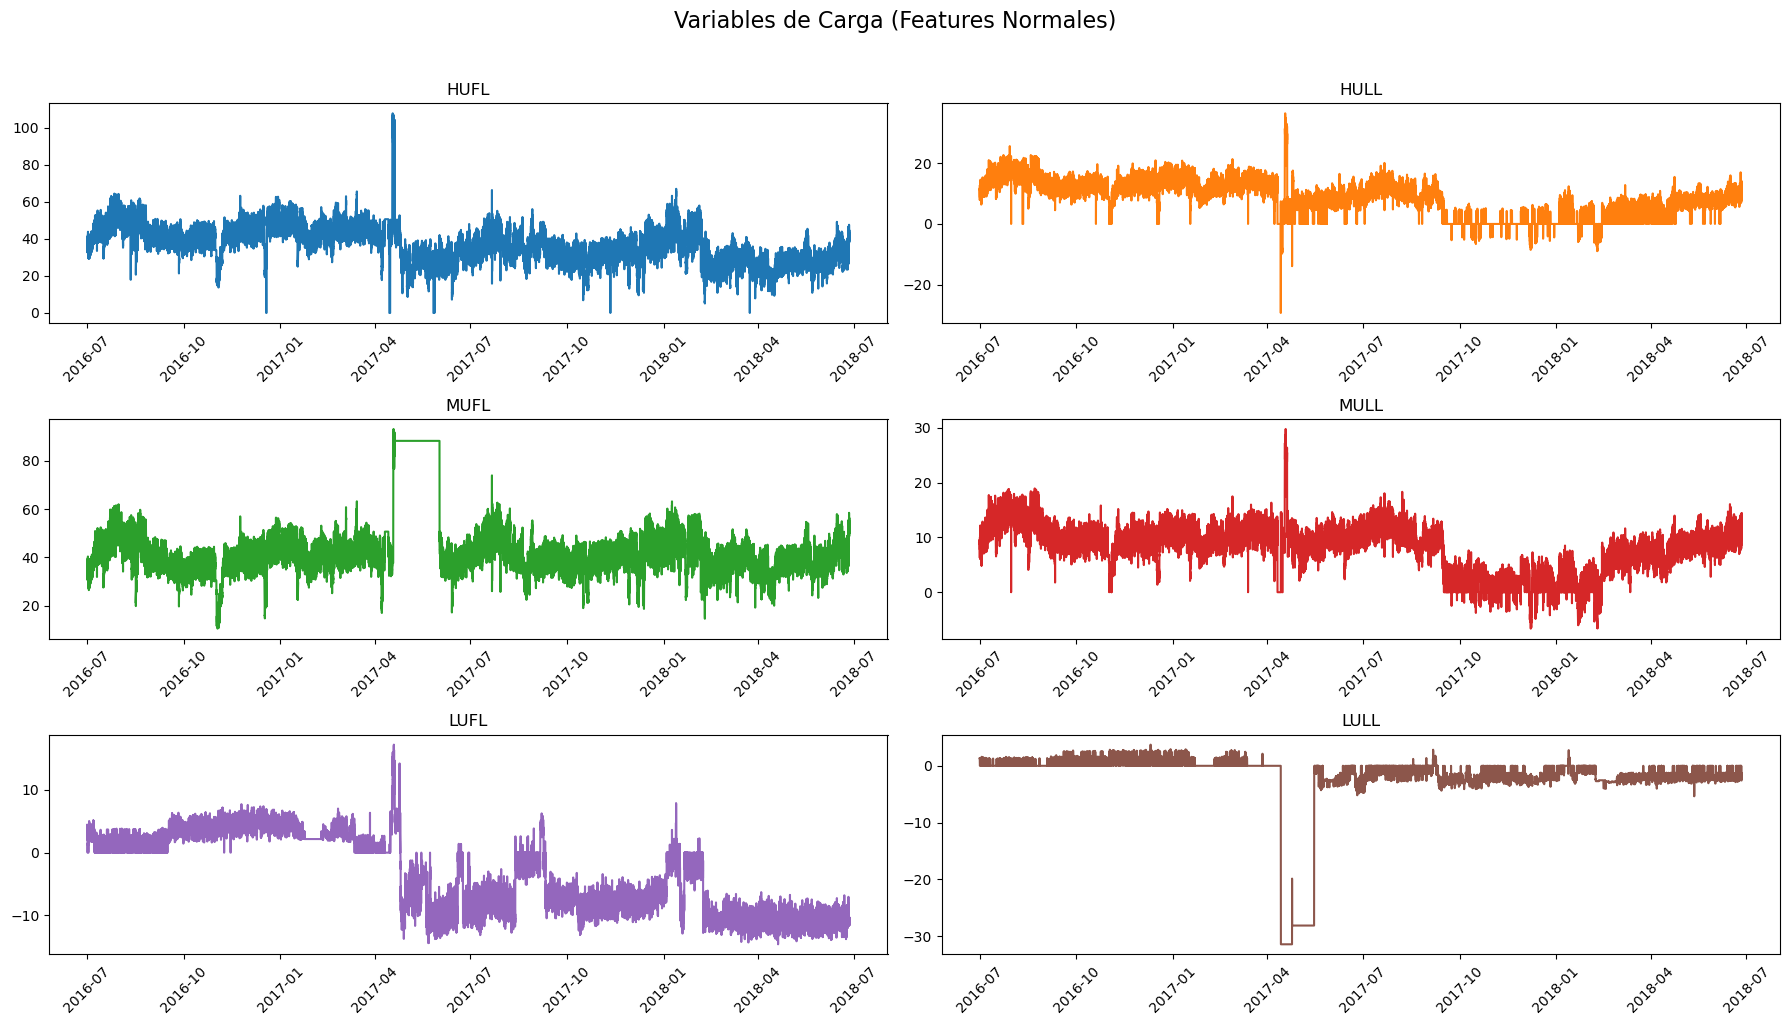

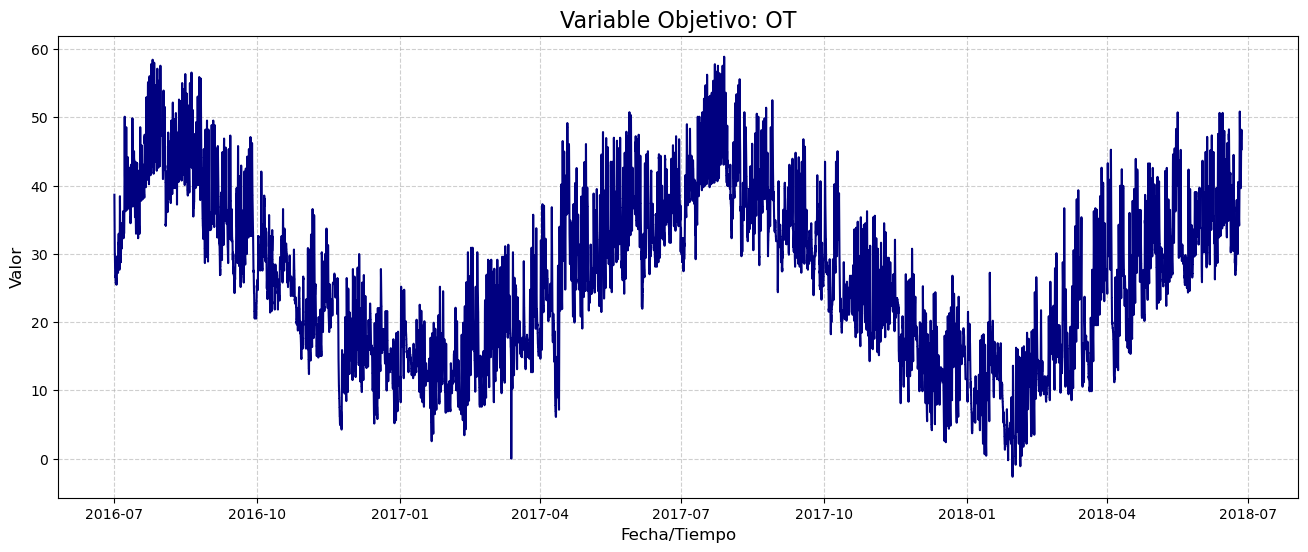

In [74]:
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
target_col   = 'OT'
plot_time_series(data, feature_cols, target_col)

## Separación en entrenamiento y prueba

In [75]:
# Agrega características de tiempo al DataFrame basado en el índice de fecha/hora.

data = add_time_features(data,datamin)
#data = add_time_features(data)

In [76]:
X = data.drop(columns=[target_col])
y = data[target_col]
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, test_size=0.25, valid_size=0.4)
X_train.shape, X_valid.shape, X_test.shape

((52260, 18), (10452, 18), (6968, 18))

## Preprocesamiento

## Escalado

In [77]:
res = scale_data(X_train, X_valid, X_test, y_train, y_valid, y_test)
X_train_s, X_valid_s, X_test_s, y_train_s, y_valid_s, y_test_s, x_scaler, y_scaler = res

## Sequencias

In [78]:
if datamin:
    SEQUENCE_LENGTH = 96 # 1 Full day = 24 hours * 4 (15 min intervals) 
else:
    SEQUENCE_LENGTH = 24 # 1 Full day = 24 hours 
    #SEQUENCE_LENGTH = SEQUENCE_LENGTH * 7 # 1 Full week
X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, SEQUENCE_LENGTH)
X_valid_seq, y_valid_seq = create_sequences(X_valid_s, y_valid_s, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test_s, SEQUENCE_LENGTH)
X_train_seq.shape, y_train_seq.shape, X_valid_seq.shape, y_valid_seq.shape, X_test_seq.shape, y_test_seq.shape

((52164, 96, 18), (52164,), (10356, 96, 18), (10356,), (6872, 96, 18), (6872,))

In [ ]:
X_train_seq

In [79]:
N_FEATURES = X_train_seq.shape[2]  # Número total de features (cargas + temporales)

# Desarrollo del modelo: 
Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.


## Construcción del Modelo

In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Concatenate, Bidirectional, Attention

def build_lstm_model(seq_len, n_feat):
    # 1. Capa de entrada
    inputs = Input(shape=(seq_len, n_feat))

    # 2. Primera LSTM (opcionalmente bidireccional)
    x = Bidirectional(LSTM(128,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2"))(inputs)

    x = LayerNormalization()(x)

    # 3. Segunda LSTM
    x2 = LSTM(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2")(x)

    x2 = LayerNormalization()(x2)

    # 4. Bloque de Atención
    attention_output = Attention()([x2, x2])  # self-attention

    # Concateno para conservar información original + atención
    x3 = Concatenate()([x2, attention_output])

    # 5. Última LSTM para condensar la secuencia
    x4 = LSTM(32,return_sequences=False,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer="l2")(x3)

    # 6. Dropout de regularización
    x4 = Dropout(0.2)(x4)

    # 7. Capa densa final (regresión)
    outputs = Dense(1)(x4)

    model = Model(inputs, outputs)
    return model


# Construcción y compilación del modelo
lstm_model = build_lstm_model(SEQUENCE_LENGTH, N_FEATURES)

optimizer = Adam(learning_rate=0.0015)

lstm_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=["mae"]
    #loss='mean_squared_error', # Para regresión
    #metrics=['mean_absolute_error'] # Métrica más interpretable
)

lstm_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 96, 256)   │    150,528 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96, 256)   │        512 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 96, 64)    │     82,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96, 64)    │        128 │ lstm_10[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 96, 64)    │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 96, 128)   │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 32)        │     20,608 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 253,985 (992.13 KB)

 Trainable params: 253,985 (992.13 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [81]:
# Early Stopping para detener el entrenamiento si la pérdida de validación deja de mejorar para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida de validación
    patience=5,                # Número de épocas sin mejora antes de detener
    restore_best_weights=True   # Mantiene los mejores pesos encontrados
)

history = lstm_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=100,                 # Un número alto, ya que Early Stopping lo detendrá
    batch_size=32,
    validation_data=(X_valid_seq, y_valid_seq),
    callbacks=[early_stop] 
)

Epoch 1/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 405s 242ms/step - loss: 0.1809 - mae: 0.1021 - val_loss: 0.0100 - val_mae: 0.1089
Epoch 2/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 356s 218ms/step - loss: 0.0074 - mae: 0.0880 - val_loss: 0.0083 - val_mae: 0.0940
Epoch 3/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 353s 216ms/step - loss: 0.0067 - mae: 0.0840 - val_loss: 0.0087 - val_mae: 0.0948
Epoch 4/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 354s 217ms/step - loss: 0.0067 - mae: 0.0834 - val_loss: 0.0093 - val_mae: 0.1030
Epoch 5/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 362s 222ms/step - loss: 0.0067 - mae: 0.0830 - val_loss: 0.0116 - val_mae: 0.1083
Epoch 6/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 357s 219ms/step - loss: 0.0070 - mae: 0.0840 - val_loss: 0.0091 - val_mae: 0.1034
Epoch 7/100
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 359s 220ms/step - loss: 0.0083 - mae: 0.0864 - val_loss: 0.0099 - val_mae: 0.1068


## Evaluación:

In [ ]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")

In [ ]:
# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_validacion = mean_absolute_error(y_true, y_pred)
print(f"MAE en la escala Real: {mae_validacion:.2f}")

# Ajuste del modelo: 
Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos (al menos una iteración).

# Resultados: 
Evaluación de modelo final con datos de prueba.


In [82]:
print("Evaluando el modelo en el conjunto de prueba...")
test_loss, test_mae = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n--- Resultados de la Prueba ---")
# El error está en la escala escalada (0 a 1)
print(f"Pérdida (MSE) en Test (escalado): {test_loss:.6f}")
print(f"Error Absoluto Medio (MAE) en Test (escalado): {test_mae:.6f}")

Evaluando el modelo en el conjunto de prueba...

--- Resultados de la Prueba ---
Pérdida (MSE) en Test (escalado): 0.005708
Error Absoluto Medio (MAE) en Test (escalado): 0.075904


215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step


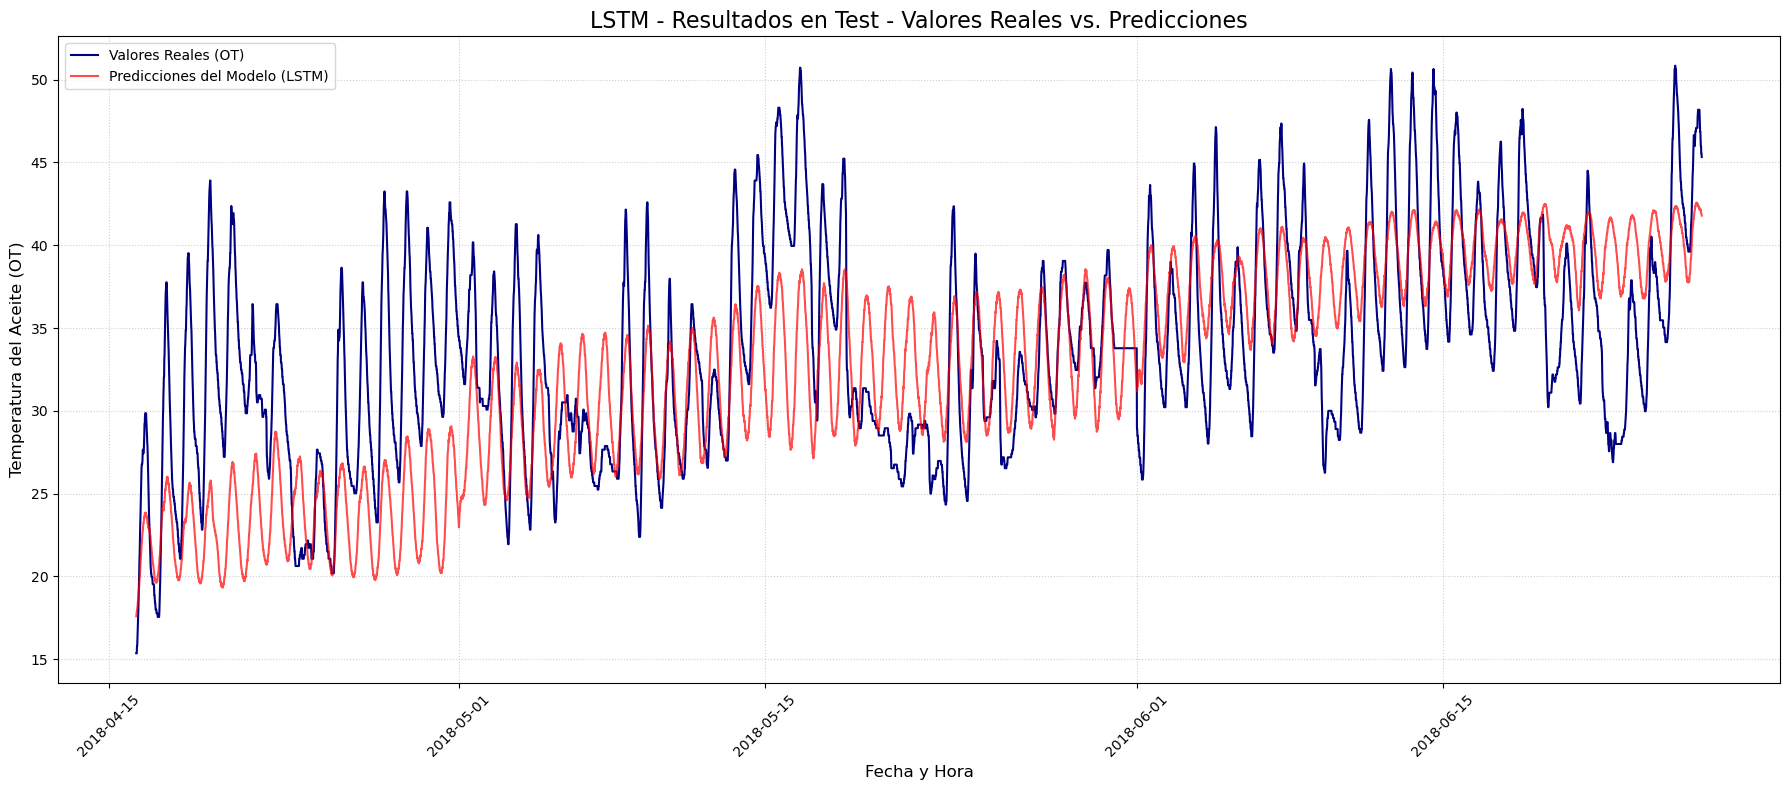

NameError: name 'mae_validacion' is not defined

In [83]:
# 1. Generar Predicciones (Aún en la escala de 0 a 1)
y_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Desescalar 
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
plot_predictions(y_true, y_pred, data.index[-len(y_true):], title_prefix="LSTM - Resultados en Test")
mae_real = mean_absolute_error(y_true, y_pred)
print(f"MAE validación en la escala Real: {mae_validacion:.2f}")
print(f"MAE FINAL en la escala Real: {mae_real:.2f}")

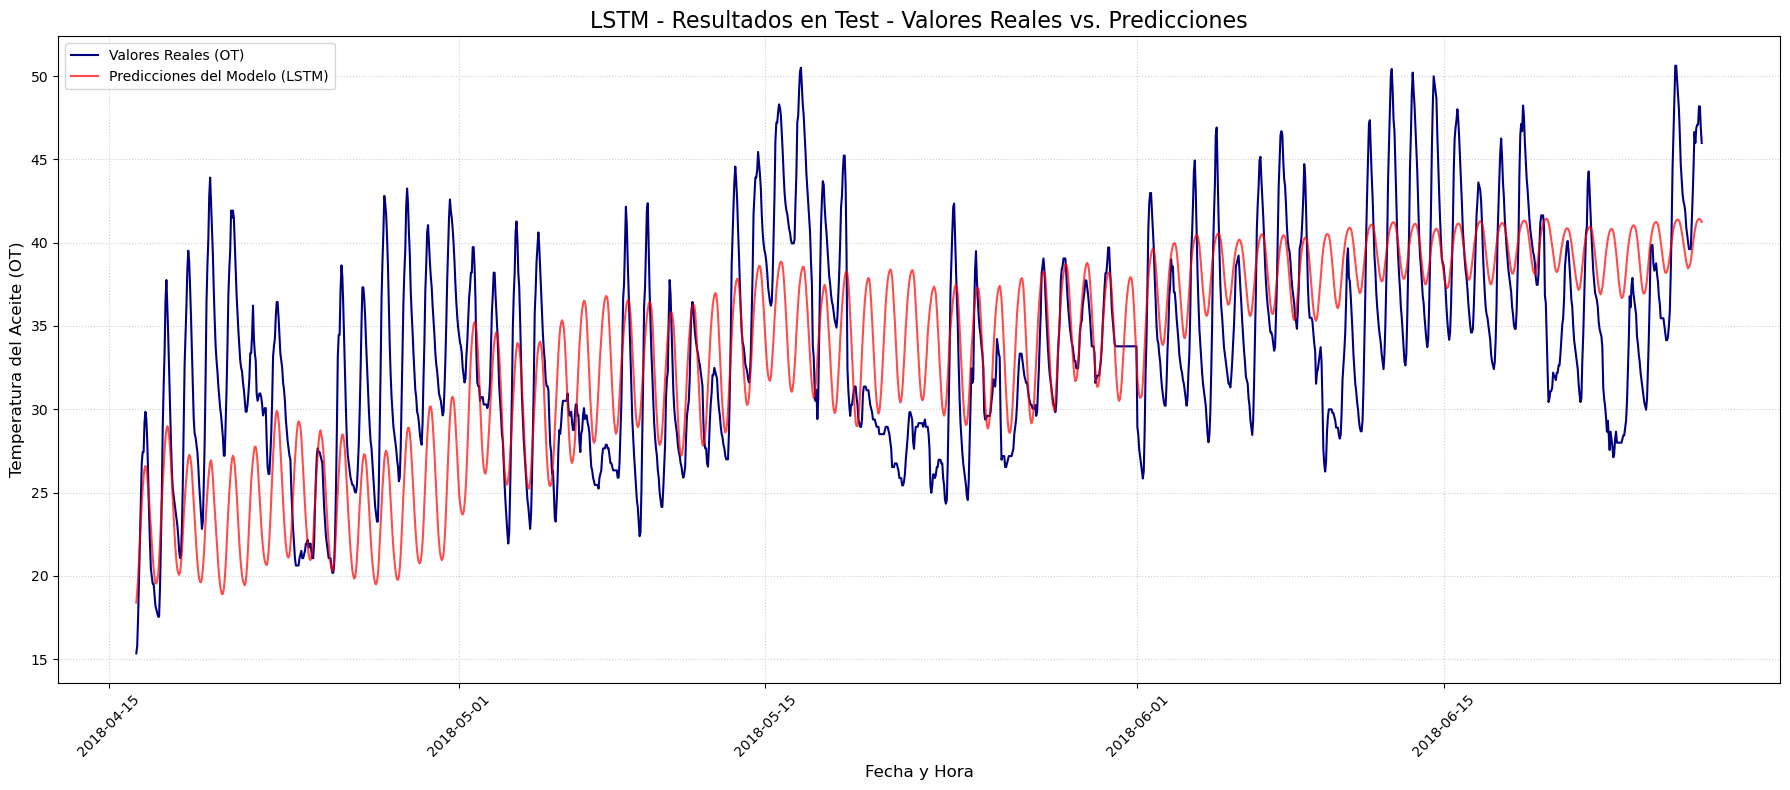

MAE en la escala Real: 4.52


# Conclusiones: 
Análisis de los resultados obtenidos, identificación de posibles áreas de mejora.


# Aplicación: 
Función para probar modelo con datos nuevos (por ejemplo, argumento=ruta a imagen, salida=resultado de clasificación).


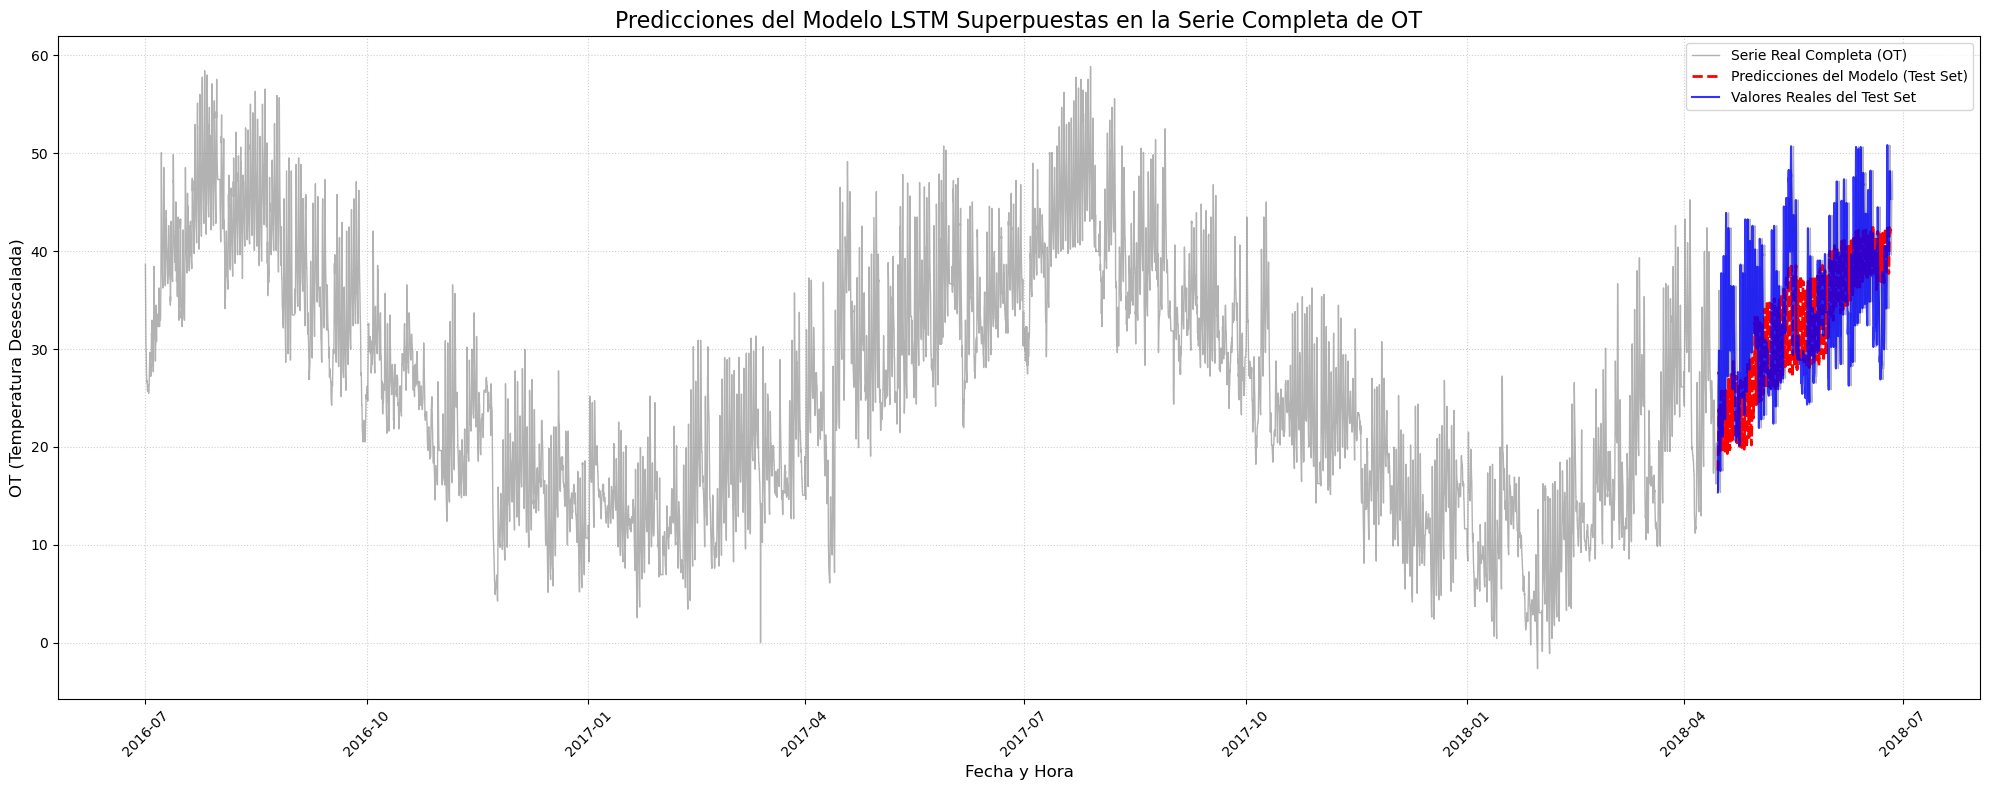

In [84]:
plot_full_series_predictions(data, target_col, y_true, y_pred, len(X_train_seq)+len(X_valid_seq), 2 *SEQUENCE_LENGTH)